In [336]:
import pandas as pd
import quandl, math
import numpy as np
import pickle

import datetime

import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostRegressor

style.use('ggplot')

quandl.ApiConfig.api_key = "Yx2Q5Mho6nhmLFsuPBY8"
df = quandl.get('WIKI/GOOGL')

# Limit Dataframe to just these columns
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# Calculate the high/low percentage + percent change
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_CHANGE'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHANGE', 'Adj. Volume']]
print(df.head())

# Declare the column of interest for labeling, Adjusted Close
forecast_col = 'Adj. Close'

# Replace any nan's with a number
df.fillna(-99999, inplace=True)

# Determine how far "out" to predict
forecast_out = int(math.ceil(0.01*len(df)))

# Create a new column that equals the Adjusted close, 0.01*len(df) in the future
df['label'] = df[forecast_col].shift(-forecast_out)
#print(df.tail())


X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

#print(len(X), len(X_lately), len(y))

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Declare model and train
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
# Write to pickle
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)


# clf = AdaBoostRegressor(n_estimators=1)
# clf.fit(X_train, y_train)
# scores = cross_val_score(clf, X_test, y_test)
# scores.mean() 

            Adj. Close    HL_PCT  PCT_CHANGE  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0


Model Accuracy: 0.9727432309586947
[  954.19395214   965.07754236   971.9559247    967.94310819   975.61024252
   974.73737829   973.04573579   973.68498637   973.4851761    976.91435453
   983.0505294    958.27290909   967.53303923   972.65769475   981.97590902
   988.32891271   995.99160003  1008.45905006  1011.33914072  1014.61691693
  1004.0726833   1006.08606396  1014.03580664  1021.64319436  1014.30082545
  1019.89310267  1022.45933533   982.25992045   975.93154429   987.40331513
   984.44870734   976.06015898   975.89255963] 0.972743230959 33


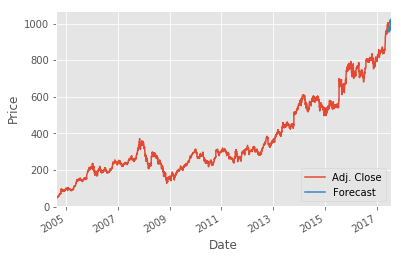

In [337]:
accuracy = clf.score(X_test, y_test)
print('Model Accuracy: {}'.format(accuracy))

forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

df["Forecast"] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range (len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()